# Data imputation on a Real Public Dataset, Herold et al. (2020)

The article “Integration of time-series meta-omics data reveals how microbial ecosystems respond to disturbance” explores the dynamic nature of microbial communities in biological wastewater treatment plants (BWWTPs) by combining metagenomics (MG), metatranscriptomics (MT), and other meta-omics approaches. The study provides a detailed analysis of these communities’ resilience and resistance to environmental disturbances. We are going to use the data from this study to perform data imputation and analysis. Specifically, we will focus on the following figures:

#### Figure 3 - Community Structure and Function Dynamics:
Figure 3 presents the community structure and function dynamics over time, focusing on the relative abundance and expression levels of microbial populations. The data are derived from recovered populations represented by reconstructed metagenome-assembled genomes (rMAGs), which show genetic composition and activity through MG and MT depth coverage, with mapping percentages of 26% ± 3% and 27% ± 3%, respectively. The relative abundance data are categorized by genus-level taxonomic assignments, and less abundant genera are grouped under “Other” if their mean abundance is below 2%.

This figure also includes ordination plots based on Bray–Curtis dissimilarity of rMAGs’ relative abundances, constrained by abiotic factors such as metabolite levels, metabolite ratios, and physicochemical parameters (shown as black arrows). The results highlight seasonal shifts and environmental influences on microbial community dynamics, with time-course sampling illustrated through connecting points and color coding by the month of sampling.

#### Figure 4 - Metabolite Levels and Environmental Dynamics:
Figure 4 presents time-series data on metabolite levels and physicochemical parameters, highlighting fluctuations in metabolite classes, types, and measurement subtypes. It uses a heatmap to display Z-score transformed intensities of metabolites and other parameters, showcasing intracellular and extracellular metabolite levels, ratios, and several environmental parameters collected manually or through continuous monitoring at a wastewater treatment plant. This data reflects how environmental and metabolite dynamics interact, impacting microbial activity and metabolism over time (Herold et al., 2020).

By focusing on these figures, our VAR (Vector Autoregression) inference and Gaussian Process imputer (GP Imputer) can leverage time-series trends and correlations between microbial populations and their environment within BWWTP systems.


In [1]:
import matplotlib.pyplot as plt
import numpy as np


import pandas as pd
import seaborn as sns


from mimic.data_imputation.impute_GP import GPImputer
from mimic.model_infer.infer_VAR_bayes import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Imputing Microbial Community Data (Figure 3) using Gaussian Process Imputer

In [ ]:
data = pd.read_csv(r'Source Data/fig3ab.tsv', delimiter='\t')

data.head(15)

### Separate the data into MG and MT datasets

The data is separated into two datasets, MG and MT. The MG dataset contains the meta-genomics data, while the MT dataset contains the meta-transcriptomics. We will be using the MG dataset in this example.


In [ ]:
# separate the data into MG and MT datasets

dataMG = data[data['type'] == 'MG']

dataMG.info()

dataMT = data[data['type'] == 'MT']

dataMT.info()

We will proceed with some data wrangling to prepare the data for the imputation process.


In [ ]:
# Data cleaning
# Rename Nan in the genus column to 'Other'

dataMG['genus'] = dataMG['genus'].replace(np.nan, 'Other')

# Drop the 'type' column
dataMG = dataMG.drop(columns=['type'])

# Change relative Date columns to days
dataMG['date'] = pd.to_datetime(dataMG['date'])
dataMG['date'] = (dataMG['date'] - dataMG['date'].min()).dt.days

# Change the 'genus' column to a categorical column
dataMG['genus'] = dataMG['genus'].astype('category')


dataMG.info()

In [ ]:
# Plot the data, relative abundance (value) vs. days (date) for each genus


sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='val', hue='genus', data=dataMG)
plt.title('Microbial Growth Data')
plt.xlabel('Days')
plt.ylabel('Relative Abundance')
plt.show()

In [ ]:
# Pivot the data so each 'genus' is a column
dataMG_pivot = dataMG.pivot(
    index='date', columns='genus', values='val').fillna(0)

# Create a stacked area chart
plt.figure(figsize=(12, 6))
plt.stackplot(dataMG_pivot.index, dataMG_pivot.T, labels=dataMG_pivot.columns)

plt.title('Microbial Growth Data')
plt.xlabel('Days')
plt.ylabel('Relative Abundance')
plt.legend(loc='upper left')

plt.show()

In [ ]:
# Do the same data cleaning for the MT data set

# Rename Nan in the genus column to 'Other'

dataMT['genus'] = dataMT['genus'].replace(np.nan, 'Other')

# Drop the 'type' column
dataMT = dataMT.drop(columns=['type'])

# Change relative Date columns to days
dataMT['date'] = pd.to_datetime(dataMT['date'])
dataMT['date'] = (dataMT['date'] - dataMT['date'].min()).dt.days

# Change the 'genus' column to a categorical column
dataMT['genus'] = dataMT['genus'].astype('category')

In [ ]:
# Plot the data, relative abundance (value) vs. days (date) for each genus


sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='val', hue='genus', data=dataMT)
plt.title('Microbial Meta Transcriptomics Data')
plt.xlabel('Days')

In [ ]:
# Pivot the data so each 'genus' is a column
dataMT_pivot = dataMT.pivot(
    index='date', columns='genus', values='val').fillna(0)

# Pivot the MG data so each 'genus' is a column
dataMG_pivot = dataMG.pivot(
    index='date', columns='genus', values='val').fillna(0)

In [ ]:

# Create a DataFrame with a complete range of days
all_days = pd.DataFrame(
    {'days': range(dataMG['date'].min(), dataMG['date'].max() + 1)})

# Reindex the pivoted DataFrame to include all days, filling missing values with None
complete_dataMG = dataMG_pivot.reindex(all_days['days'])

complete_dataMG.head(15)

In [ ]:
complete_dataMG.columns

If we pick one column, say 'Acinetobacter', we can see that there are missing values in the dataset. We will use the GP imputator to fill in the missing values.

In [ ]:
complete_dataMG['Acinetobacter'].isnull().sum()

In [ ]:
# Reset the index
complete_dataMG_reset = complete_dataMG.reset_index()

# Make index as float
complete_dataMG_reset['days'] = complete_dataMG_reset['days'].astype(float)

In [ ]:
# Now 'days' is a regular column and you can use it as a feature
new_dataset = GPImputer().impute_missing_values(
    complete_dataMG_reset, ['days'], ['Acidimicrobium',
                                      'Acinetobacter', 'Albidiferax'], 'Acinetobacter'
)

In [ ]:
new_dataset['Acinetobacter'].isnull().sum()

We can see now that the data imputator calculated the missing values for the 'Acinetobacter' column. However, as we can see fro the graph, the imputed values are not great. This can be caused by multiple factors, so we are going to explore different methods to better impute the missing values. 

We are first going to try to do imputation using VGP imputation. This is a variational Gaussian process imputation method that is more robust to missing data and uses multiple imputs to calculate the missing values. However, as we will see, this method creates an imputation that is heavily biased by other imputs, so it doesn't work in our case to determine the missing values of the 'Acinetobacter' column.

In [ ]:
# Now 'days' is a regular column and you can use it as a feature
new_dataset = GPImputer().impute_missing_values(
    complete_dataMG_reset, ['days'], ['Acidimicrobium', 'Acinetobacter', 'Albidiferax',
                                      'Candidatus Microthrix', 'Chitinophaga pinensis',
                                      'Dechloromonas', 'Haliscomenobacter', 'Intrasporangium',
                                      'Leptospira', 'Other', 'Xanthomonas', 'mean abundance < 2%'], 'Acinetobacter'
)

If we, isntead, do a single imputation using only a GPR model with a single imput ('Acinetobacter'), we can see that the imputation is much better. This is because the imputation is not biased by other imputs, and the model can better predict the missing values.

In [ ]:
# Now 'days' is a regular column and you can use it as a feature
new_dataset2 = GPImputer().impute_missing_values(
    complete_dataMG_reset, ['days'], ['Acinetobacter'], 'Acinetobacter'
)

In [ ]:
# Save the dataset (new_dataset2) to a csv file
new_dataset2.to_csv(r'imputed_data.csv', index=False)

So we will proceed to do a single imput GPR model for all the columns in the dataset. We will then use the VAR inference method to infer the causal relationships between the variables in the time series.

In [ ]:
# do the imputation for each column (genus) in the dataset
# Copy the original dataset
new_dataset_complete = complete_dataMG_reset.copy()

for genus in complete_dataMG.columns:
    # Impute the missing values for the current column
    imputed_data = GPImputer().impute_missing_values(
        complete_dataMG_reset, ['days'], [genus], genus
    )

    # Update the column in the new dataset with the imputed data
    new_dataset_complete[genus] = imputed_data[genus]

# Save the dataset (new_dataset_complete) to a csv file
new_dataset_complete.to_csv('imputed_data.csv', index=False)

## Imputing Metabolite Data (Figure 4) using Gaussian Process Imputer

In [2]:
metabolites = pd.read_csv(r'Source Data/fig4.tsv', delimiter='\t')

This dataset contains several columns, each representing different attributes related to microbial activity and metabolite concentrations. Here is a detailed explanation of each column:

- **date**: The date when the sample was collected.
- **L1**: The functional category or pathway associated with the data point.
- **mp_tot**: Total metaproteomic count for that date and pathway.
- **mt_tot**: Total metatranscriptomic count for that date and pathway.
- **L1sum_MP**: Sum of metaproteomic counts for that specific functional category (L1).
- **L1sum_MT**: Sum of metatranscriptomic counts for that specific functional category (L1).
- **L1rel_MP**: Relative abundance of metaproteomic counts within the functional category.
- **L1rel_MT**: Relative abundance of metatranscriptomic counts within the functional category.
- **MP_std_L1**: Standard deviation of metaproteomic counts for that functional category.
- **MT_std_L1**: Standard deviation of metatranscriptomic counts for that functional category.
- **cor**: Correlation value between metaproteomic and metatranscriptomic data for that pathway.
- **newL1**: A reformatted version of the functional category name, often including a correlation coefficient (r value) for easier readability in the figure.

We will be using the `L1rel_MP` and `L1rel_MT` columns in this example to use it with the VAR inference method to infer the causal relationships between the variables in the time series with the meta transcriptomics (MT) and meta genomics (MG) data.

In [3]:
# Letr's create 2 dataframes, one for the L1rel_MP and the other for the L1rel_MT data, using the date, L1 and L2tel values

dataL1_MP = metabolites[['date', 'L1', 'L1rel_MP']]

dataL1_MT = metabolites[['date', 'L1', 'L1rel_MT']]
dataL1_MP.head(15)

,date,L1,L1rel_MP
0,2011-03-21,01_Fermentation,0.096899
1,2011-03-21,02_Homoacetogenesis,0.009890
2,2011-03-21,03_Superpathway of thiosulfate metabolism (Des...,0.000579
3,2011-03-21,"04_Utililization of sugar, conversion of pento...",0.000535
4,2011-03-21,05_Fatty acid oxidation,0.025483
5,2011-03-21,06_Amino acid utilization biosynthesis metabolism,0.122784
6,2011-03-21,07_Nucleic acid metabolism,0.119531
7,2011-03-21,08_Hydrocarbon degradation,0.005524
8,2011-03-21,09_Carbohydrate Active enzyme - CAZy,0.003921
9,2011-03-21,10_TCA cycle,0.045398


c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


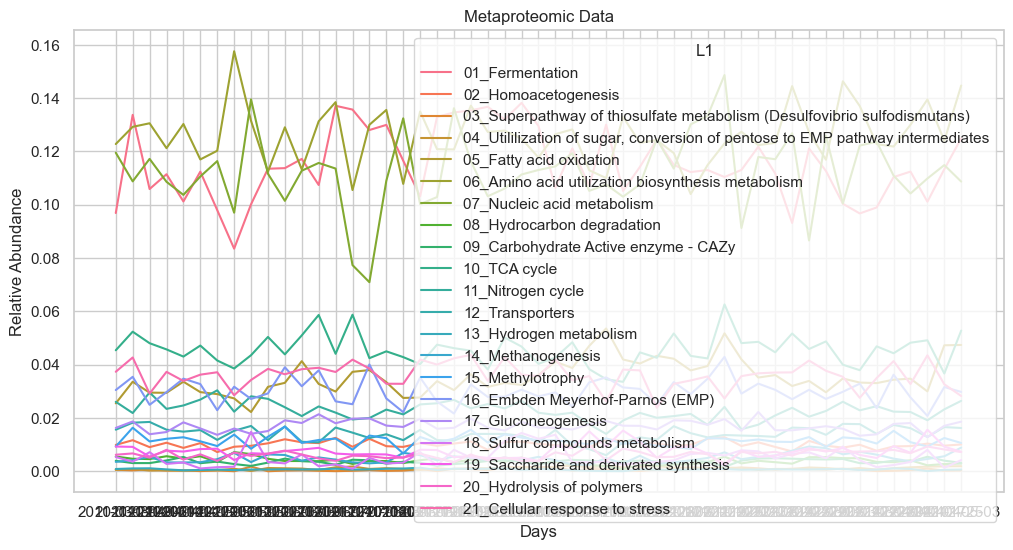

In [4]:
# Now let's visualize the data

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='L1rel_MP', hue='L1', data=dataL1_MP)
plt.title('Metaproteomic Data')
plt.xlabel('Days')
plt.ylabel('Relative Abundance')
plt.show()

c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


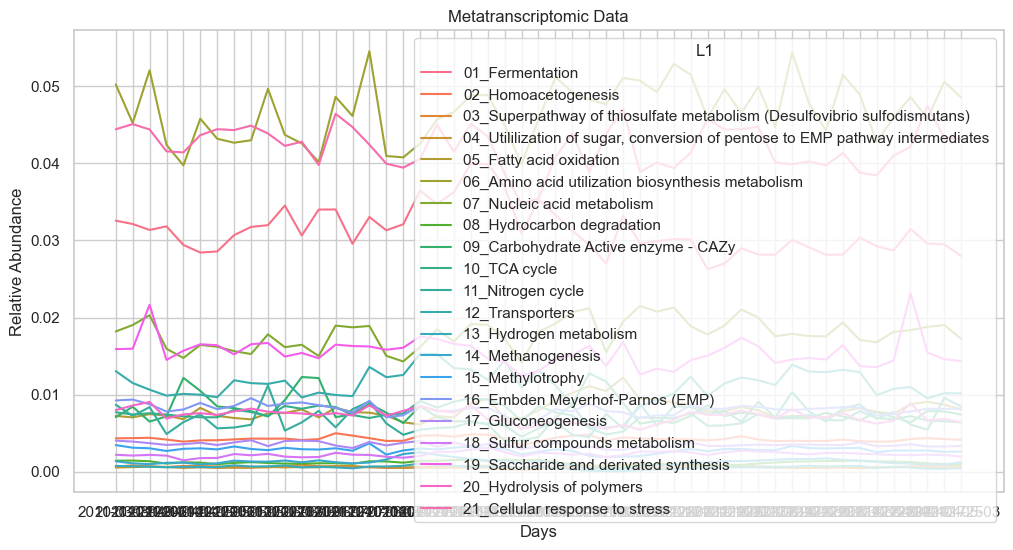

In [5]:
# Same for the metatranscriptomic data

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='L1rel_MT', hue='L1', data=dataL1_MT)
plt.title('Metatranscriptomic Data')
plt.xlabel('Days')
plt.ylabel('Relative Abundance')
plt.show()

In [6]:
# And do the same as we did for the MG and MT data sets

# Rename Nan in the L1 column to 'Other'

dataL1_MP['L1'] = dataL1_MP['L1'].replace(np.nan, 'Other')

# Change relative Date columns to days
dataL1_MP['date'] = pd.to_datetime(dataL1_MP['date'])
dataL1_MP['date'] = (dataL1_MP['date'] - dataL1_MP['date'].min()).dt.days

# Change the 'L1' column to a categorical column
dataL1_MP['L1'] = dataL1_MP['L1'].astype('category')

C:\Users\User\AppData\Local\Temp\ipykernel_32172\300627487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataL1_MP['L1'] = dataL1_MP['L1'].replace(np.nan, 'Other')
C:\Users\User\AppData\Local\Temp\ipykernel_32172\300627487.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataL1_MP['date'] = pd.to_datetime(dataL1_MP['date'])
C:\Users\User\AppData\Local\Temp\ipykernel_32172\300627487.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

C:\Users\User\AppData\Local\Temp\ipykernel_32172\4211173979.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataL1_MT['L1'] = dataL1_MT['L1'].replace(np.nan, 'Other')
C:\Users\User\AppData\Local\Temp\ipykernel_32172\4211173979.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataL1_MT['date'] = pd.to_datetime(dataL1_MT['date'])
C:\Users\User\AppData\Local\Temp\ipykernel_32172\4211173979.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

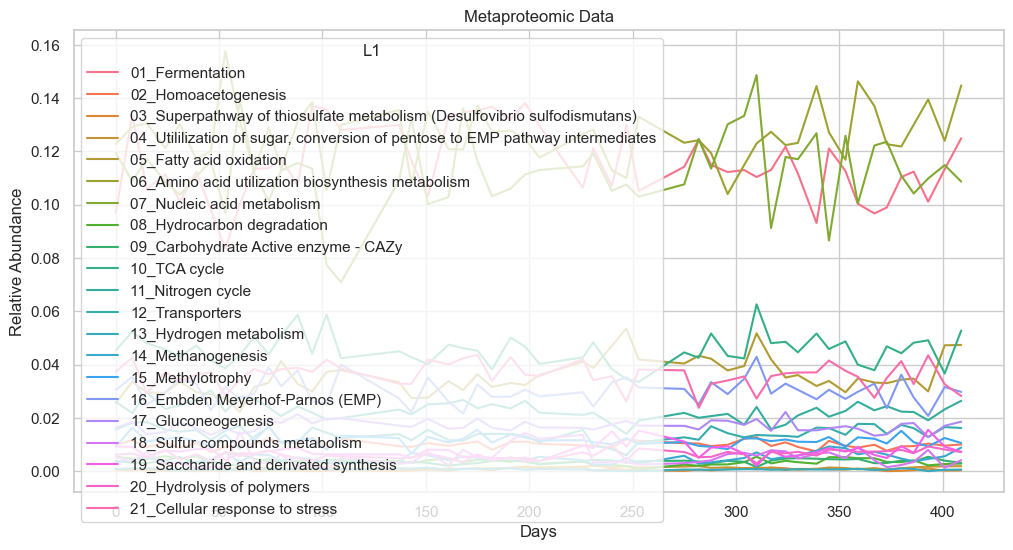

In [7]:
# do the same for the L1rel_MT data set

# Rename Nan in the L1 column to 'Other'

dataL1_MT['L1'] = dataL1_MT['L1'].replace(np.nan, 'Other')

# Change relative Date columns to days
dataL1_MT['date'] = pd.to_datetime(dataL1_MT['date'])
dataL1_MT['date'] = (dataL1_MT['date'] - dataL1_MT['date'].min()).dt.days

# Change the 'L1' column to a categorical column
dataL1_MT['L1'] = dataL1_MT['L1'].astype('category')

# Plot the data, relative abundance (value) vs. days (date) for each L1


sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='L1rel_MP', hue='L1', data=dataL1_MP)
plt.title('Metaproteomic Data')
plt.xlabel('Days')
plt.ylabel('Relative Abundance')
plt.show()

In [8]:
# And now pivot the data so each 'L1' is a column for each data set

dataL1_MP_pivot = dataL1_MP.pivot(
    index='date', columns='L1', values='L1rel_MP').fillna(0)

dataL1_MT_pivot = dataL1_MT.pivot(
    index='date', columns='L1', values='L1rel_MT').fillna(0)

In [9]:
# Step 1: Determine the minimum and maximum index
min_index = dataL1_MP_pivot.index.min()
max_index = dataL1_MP_pivot.index.max()

# Step 2: Create a new index range from min_index to max_index
new_index = range(int(min_index), int(max_index) +
                  1)  # Ensure it's an integer range

# Step 3: Re-index the DataFrame
dataL1_MP_complete = dataL1_MP_pivot.reindex(new_index)

dataL1_MP_complete.head(15)

L1,01_Fermentation,02_Homoacetogenesis,03_Superpathway of thiosulfate metabolism (Desulfovibrio sulfodismutans),"04_Utililization of sugar, conversion of pentose to EMP pathway intermediates",05_Fatty acid oxidation,06_Amino acid utilization biosynthesis metabolism,07_Nucleic acid metabolism,08_Hydrocarbon degradation,09_Carbohydrate Active enzyme - CAZy,10_TCA cycle,...,12_Transporters,13_Hydrogen metabolism,14_Methanogenesis,15_Methylotrophy,16_Embden Meyerhof-Parnos (EMP),17_Gluconeogenesis,18_Sulfur compounds metabolism,19_Saccharide and derivated synthesis,20_Hydrolysis of polymers,21_Cellular response to stress
date,,,,,,,,,,,,,,,,,,,,,
0,0.096899,0.009890,0.000579,0.000535,0.025483,0.122784,0.119531,0.005524,0.003921,0.045398,...,0.015593,0.000846,0.003520,0.009267,0.030473,0.016261,0.005346,0.009267,0.006193,0.037334
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.133734,0.011645,0.000340,0.000870,0.033575,0.129235,0.108779,0.004688,0.003063,0.052367,...,0.018224,0.001059,0.004159,0.016334,0.035428,0.018678,0.003592,0.009150,0.006692,0.042688


In [10]:
# Reset the index
complete_dataMP_reset = dataL1_MP_complete.reset_index()

# Make index as float
complete_dataMP_reset['date'] = complete_dataMP_reset['date'].astype(float)

We are going to use the GP imputer to fill in the missing values in the dataset. We will then use the VAR inference method to infer the causal relationships between the variables in the time series. Note how we are only using the matern (M32, M12, and M52) and radial basis function (RBF) kernels in the GP imputer. This is because these kernels are the most suitable for time series data.

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern52'>
BIC: 305.14796205640255


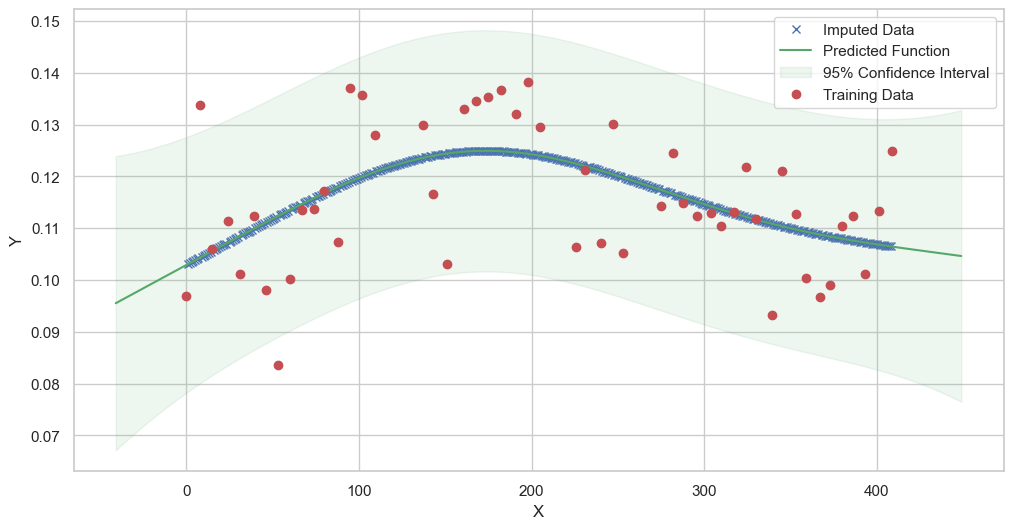

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern52'>
BIC: 539.9907420516718


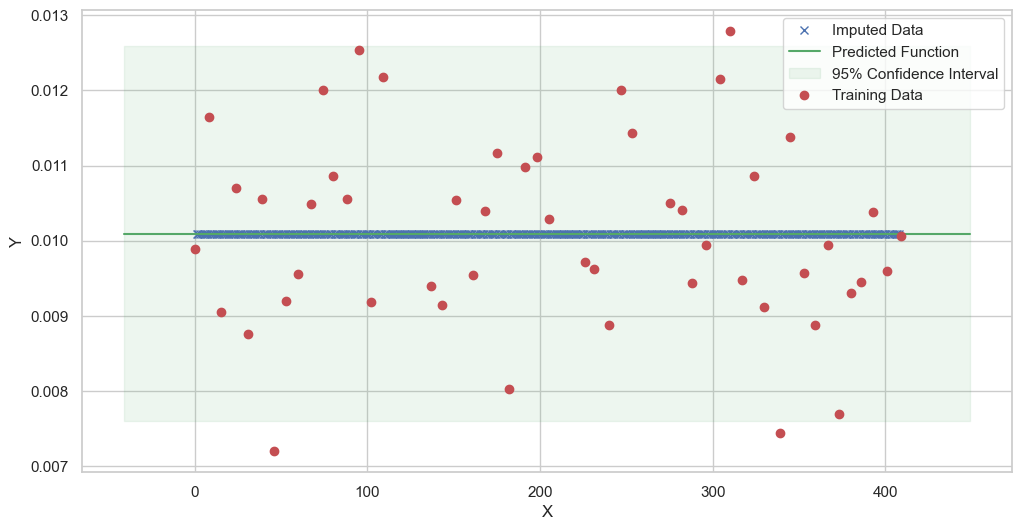

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern12'>
BIC: 593.6954527249973


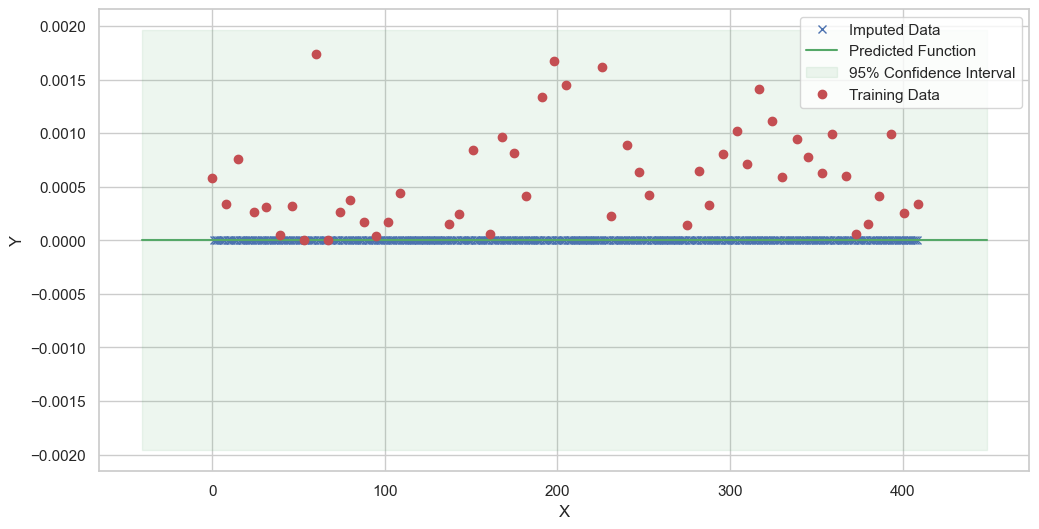

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern52'>
BIC: 606.429158574828


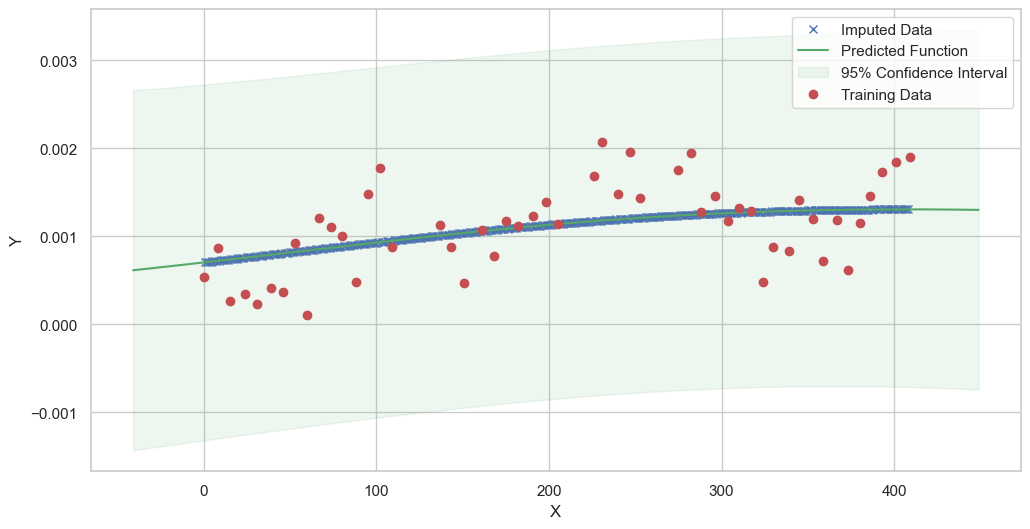

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern12'>
BIC: 389.2225921347663


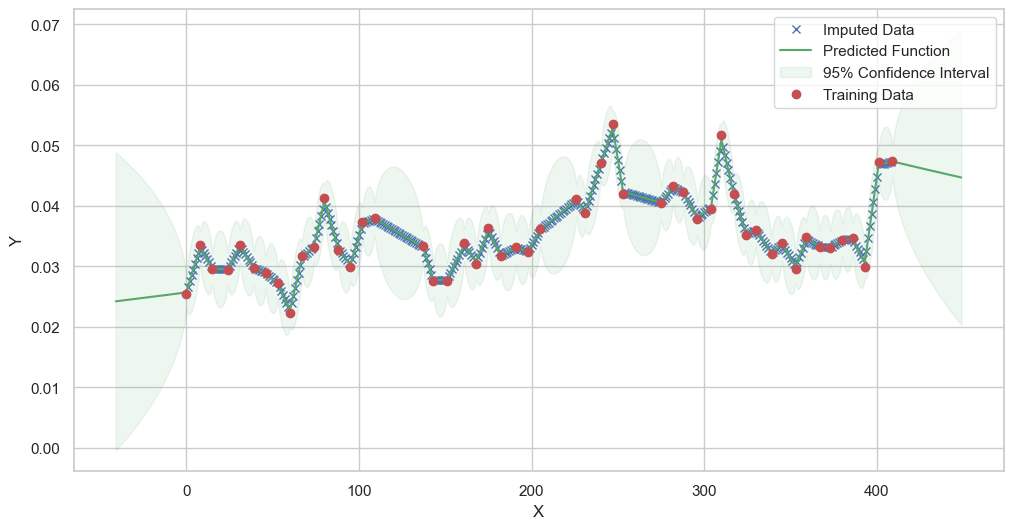

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern52'>
BIC: 321.45473434185317


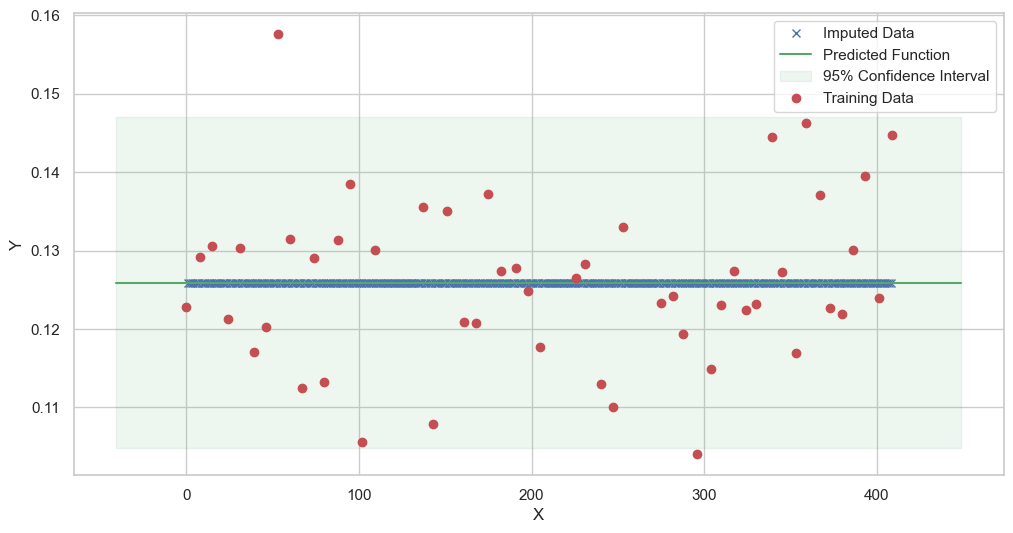

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: 292.9620322625907


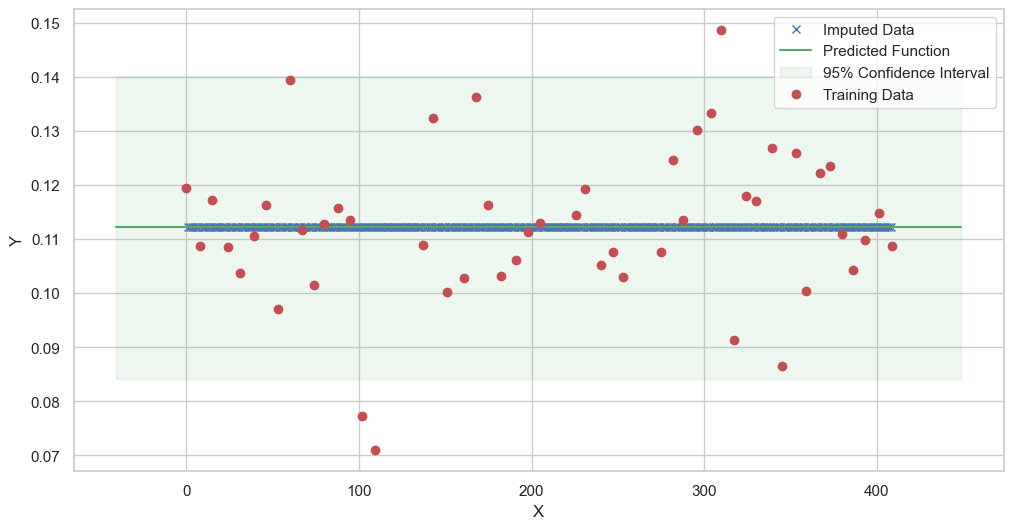

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern12'>
BIC: 558.9765129518931


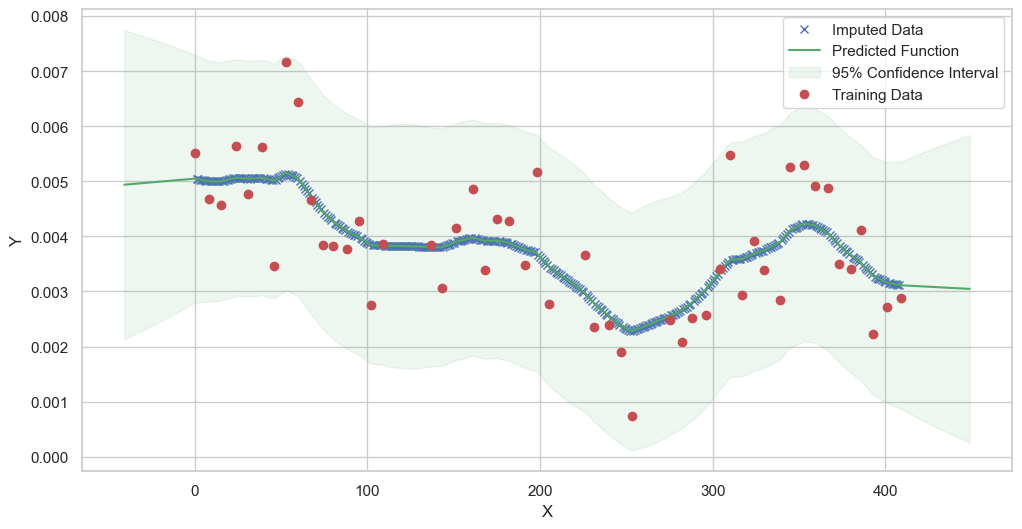

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: 581.8255133135826


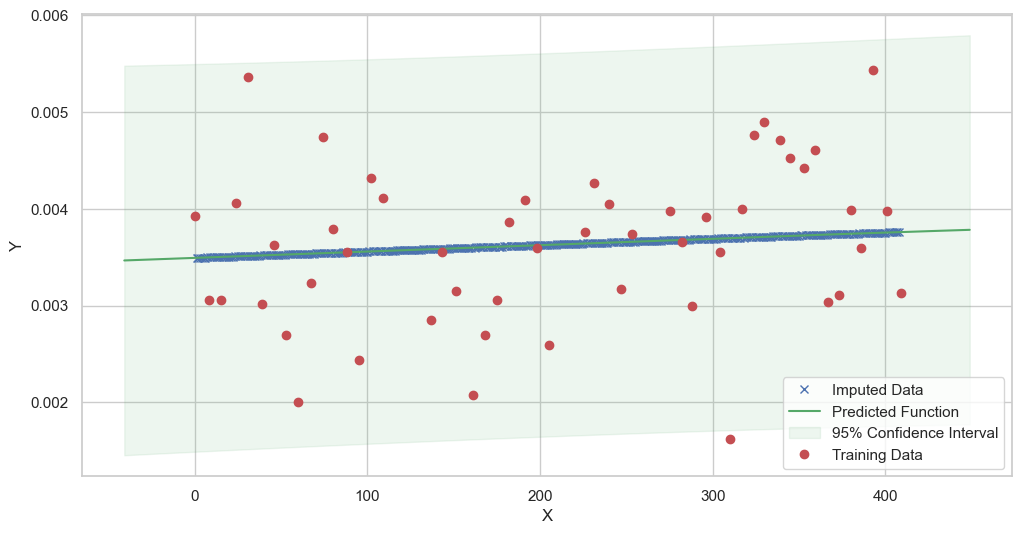

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: 384.214449988753


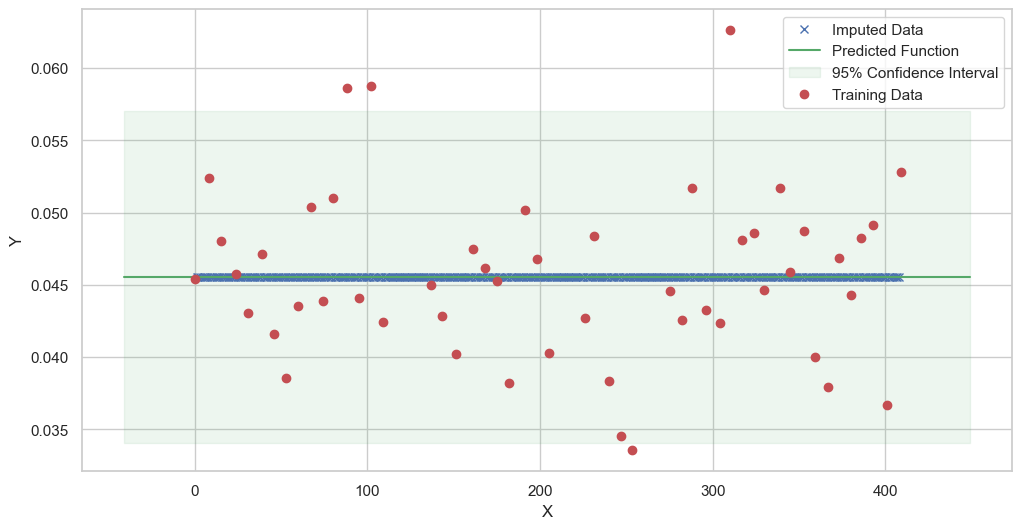

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: 448.7262491062683


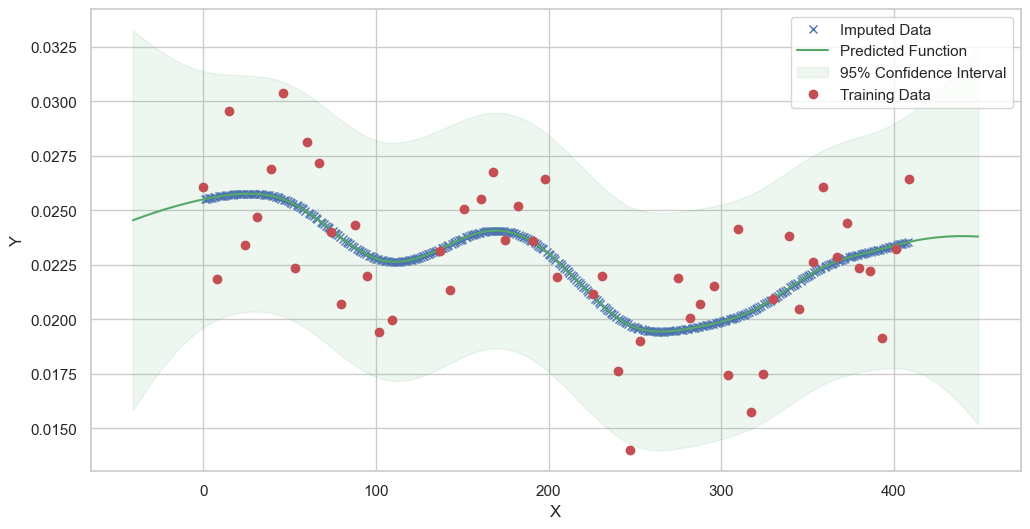

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: 475.6907363223153


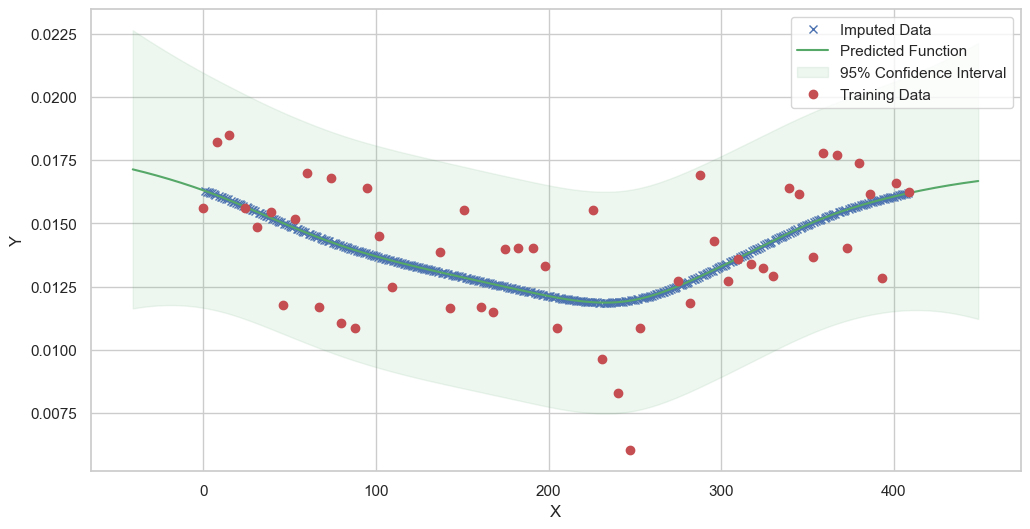

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: 595.2739514099666


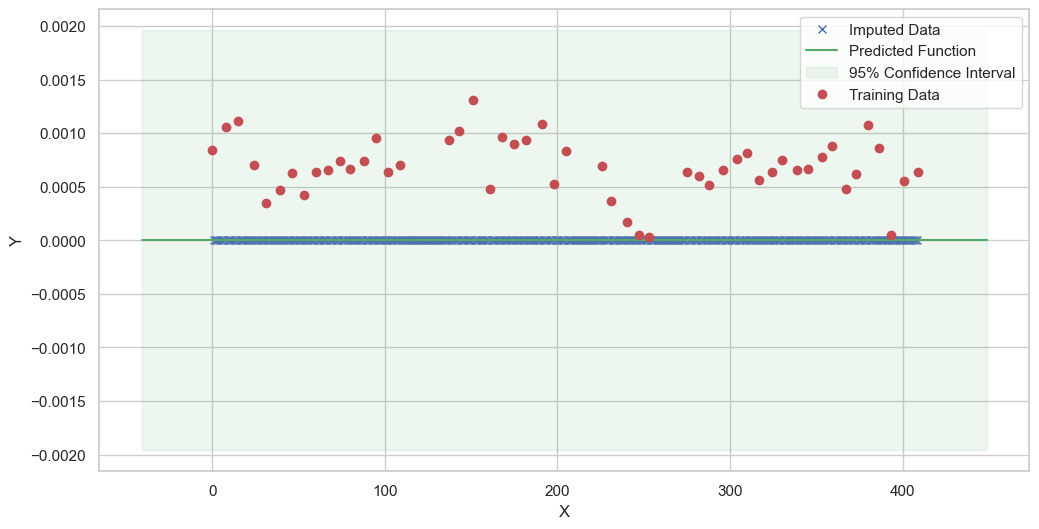

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern12'>
BIC: 523.8038498902097


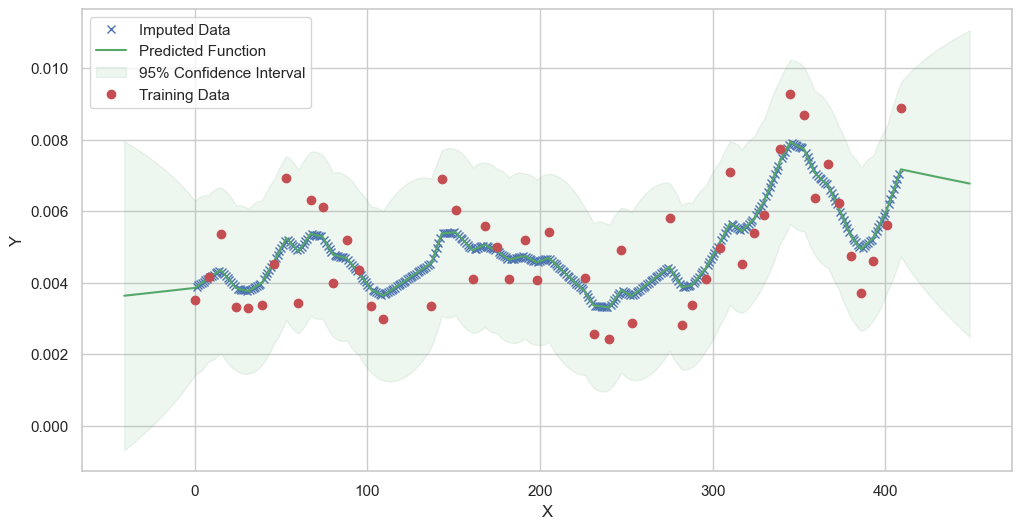

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern52'>
BIC: 492.72580947714255


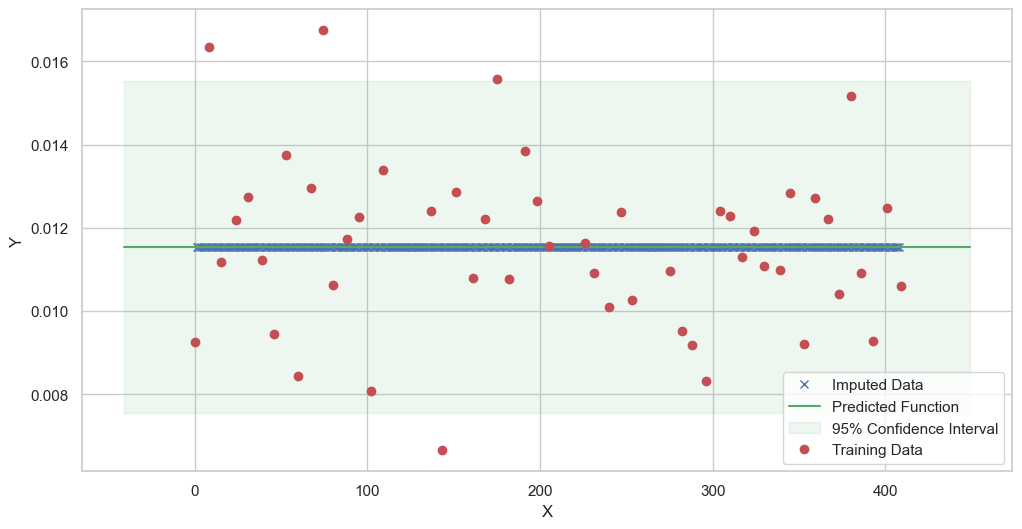

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: 404.635080730377


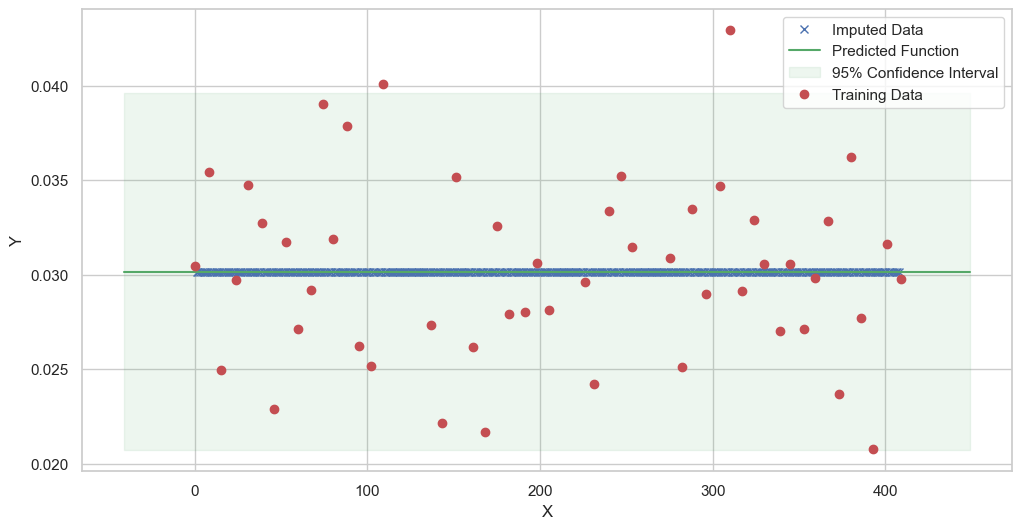

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: 488.89321087777034


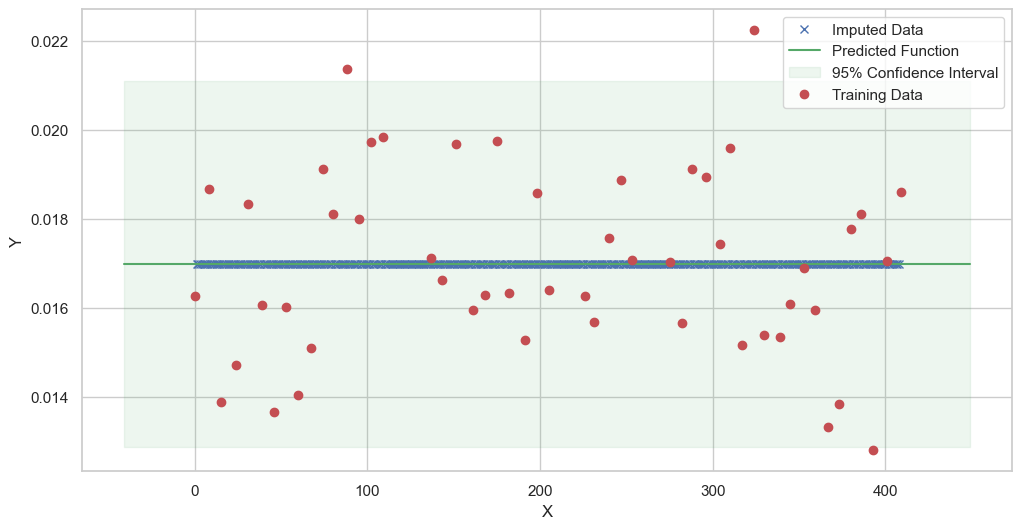

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern12'>
BIC: 443.5037096251963


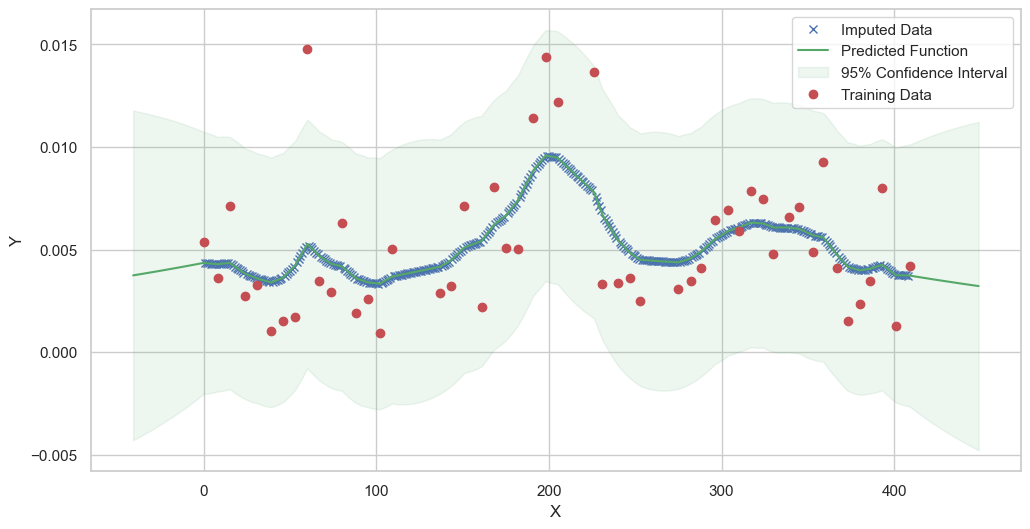

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: 466.12061932819296


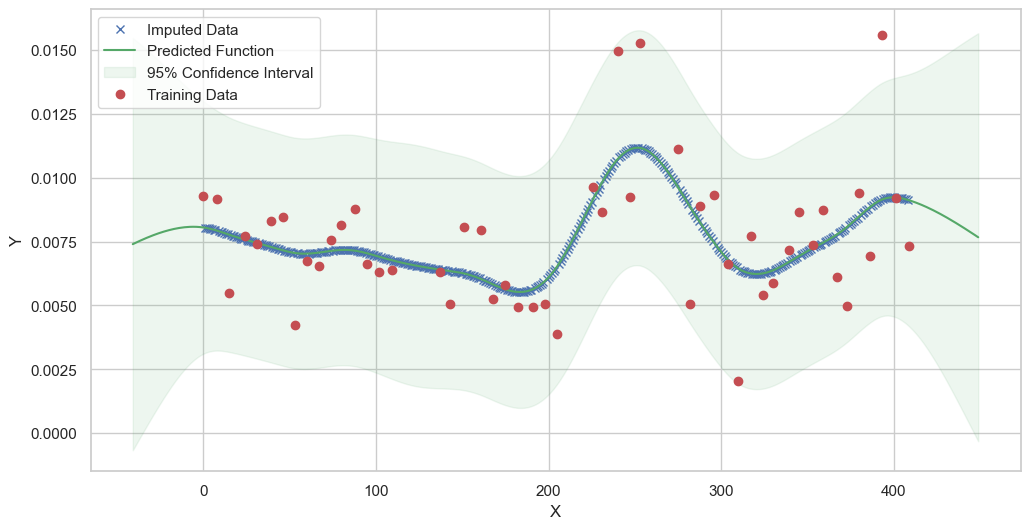

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern12'>
BIC: 520.4635688670087


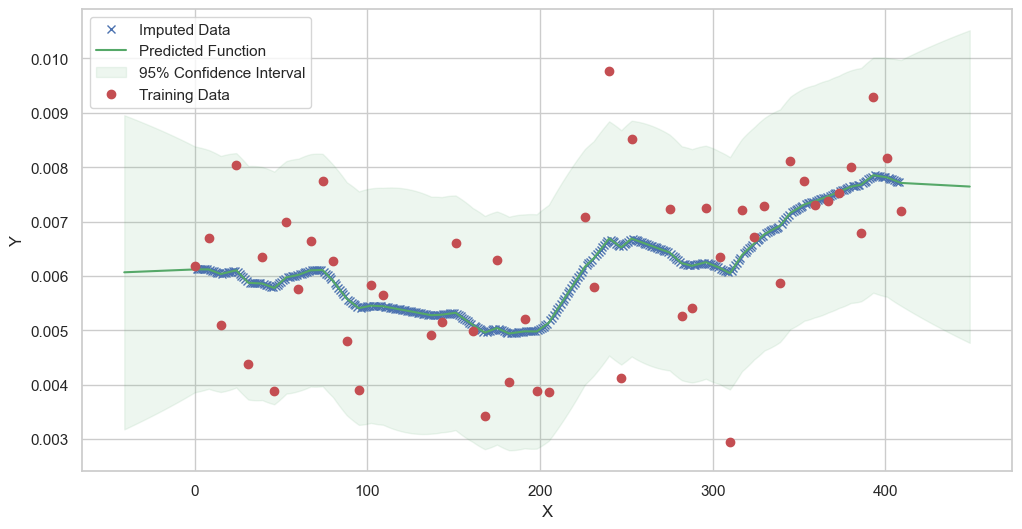

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: 405.9096561312746


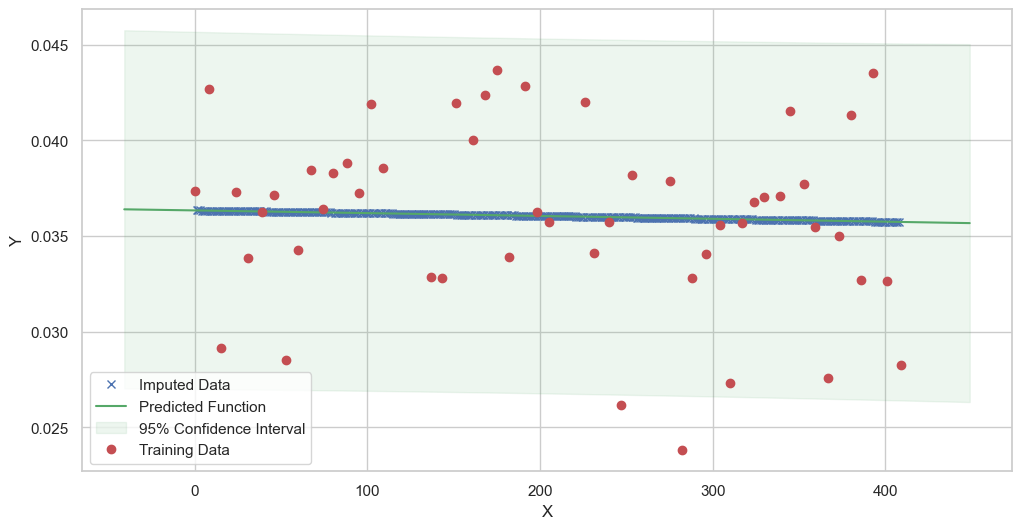

In [11]:
# do the imputation for each column (metabolite) in the dataset
# Copy the original dataset
new_dataset_complete = complete_dataMP_reset.copy()

for metabolite in dataL1_MP_complete.columns:
    # Impute the missing values for the current column
    imputed_data = GPImputer().impute_missing_values(
        complete_dataMP_reset, ['date'], [metabolite], metabolite, kernel=['M32', 'M12', 'M52', 'RBF']
    )

    # Update the column in the new dataset with the imputed data
    new_dataset_complete[metabolite] = imputed_data[metabolite]

In [12]:
# Save the dataset (new_dataset_complete) to a csv file
new_dataset_complete.to_csv('MP_metabolite_imputed_data.csv', index=False)

In [ ]:
# Let's do the same for the MT dataset

# Step 1: Determine the minimum and maximum index
min_index = dataL1_MT_pivot.index.min()
max_index = dataL1_MT_pivot.index.max()

# Step 2: Create a new index range from min_index to max_index
new_index = range(int(min_index), int(max_index) +
                  1)  # Ensure it's an integer range

# Step 3: Re-index the DataFrame
dataL1_MT_complete = dataL1_MT_pivot.reindex(new_index)

dataL1_MT_complete.head(15)

In [ ]:
# Reset the index
complete_dataMT_reset = dataL1_MT_complete.reset_index()

# Make index as float
complete_dataMT_reset['date'] = complete_dataMT_reset['date'].astype(float)

In [ ]:
# do the imputation for each column (metabolite) in the dataset
# Copy the original dataset
new_dataset_complete = complete_dataMT_reset.copy()

for metabolite in dataL1_MT_complete.columns:
    # Impute the missing values for the current column
    imputed_data = GPImputer().impute_missing_values(
        complete_dataMT_reset, ['date'], [metabolite], metabolite, kernel=['M32', 'M12', 'M52', 'RBF']
    )

    # Update the column in the new dataset with the imputed data
    new_dataset_complete[metabolite] = imputed_data[metabolite]

# Save the dataset (new_dataset_complete) to a csv file
new_dataset_complete.to_csv('MT_metabolite_imputed_data.csv', index=False)